In [ ]:
import pandas as pd
import os
import numpy as np
from numpy.random import seed
from numpy.random import randn
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import matplotlib as mlp
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


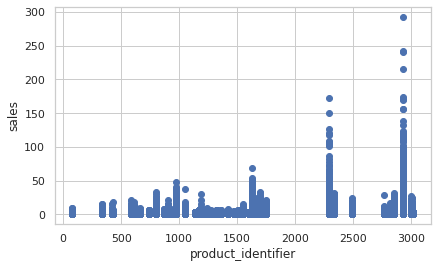

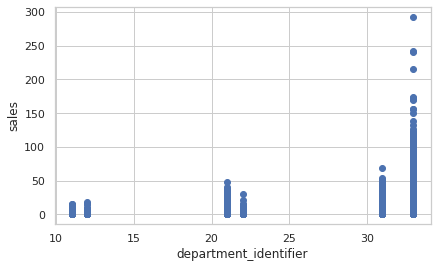

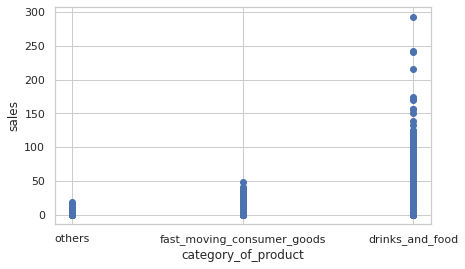

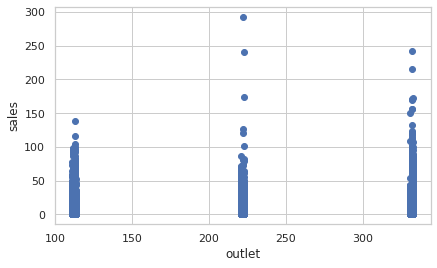

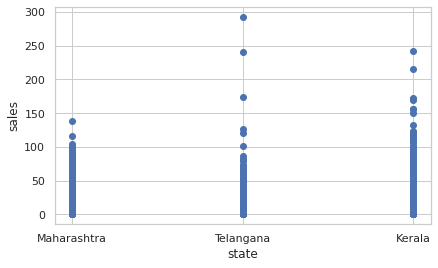

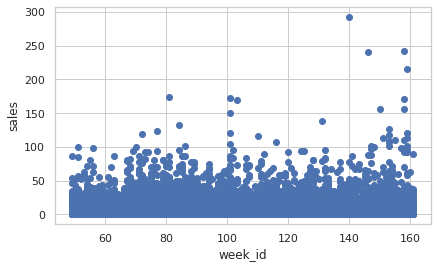

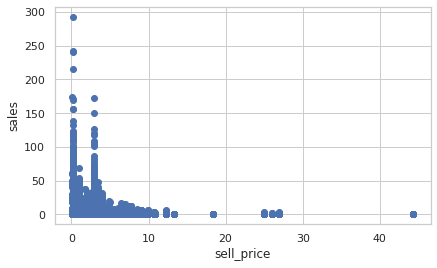

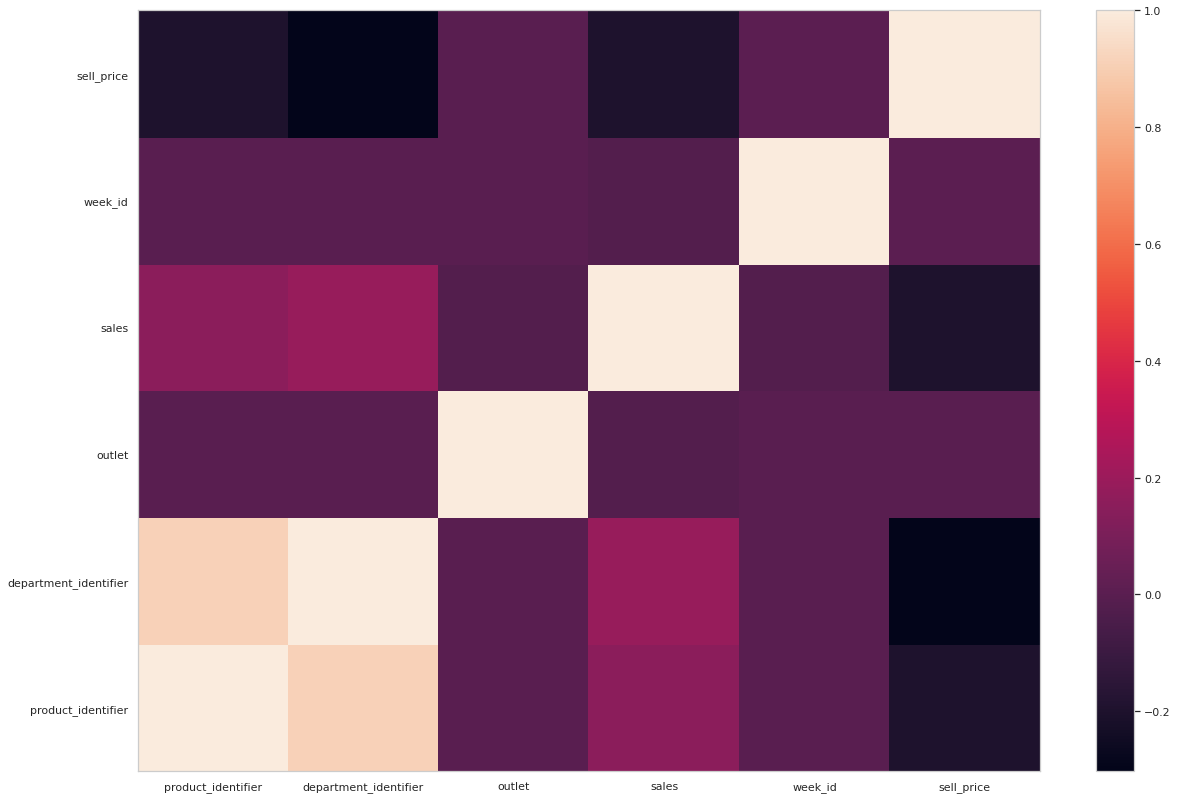

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
############################################################
plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set(style="whitegrid")

import math
%config IPCompleter.greedy=True

import csv
import time

import scipy.stats as stats

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

dataset = pd.read_csv("/content/train_data.csv", names=['date','product_identifier','department_identifier','category_of_product','outlet','state','sales'],sep=',', header=0)
prod_price = pd.read_csv("/content/product_prices.csv",sep=',', header=0,names=['outlet','product_identifier','week_id','sell_price'])
date_week = pd.read_csv("/content/date_to_week_id_map.csv",sep=',',header=0, names=['date','week_id'])

dataset.shape, prod_price.shape, date_week.shape

df=pd.merge(prod_price,date_week, on=['week_id'], how='inner')
dataset=pd.merge(dataset,df, on=['date','product_identifier','outlet'], how='inner')
dataset

dataset.describe()

dataset.head(5)

dataset.tail(5)

dataset.isnull().sum()
dataset.dtypes
col = ['category_of_product', 'state']
dataset[col] = dataset[col].astype('category')
dataset.dtypes
def scatter(dataset, column):
    plt.figure()
    ########################
    plt.scatter(dataset[column] , dataset['sales'])
    plt.ylabel('sales')
    plt.xlabel(column)
scatter(dataset, 'product_identifier')
scatter(dataset, 'department_identifier')
scatter(dataset, 'category_of_product')
scatter(dataset, 'outlet')
scatter(dataset, 'state')
scatter(dataset, 'week_id')
scatter(dataset, 'sell_price')

##################

##################


fig = plt.figure(figsize=(18, 14))
corr = dataset.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)


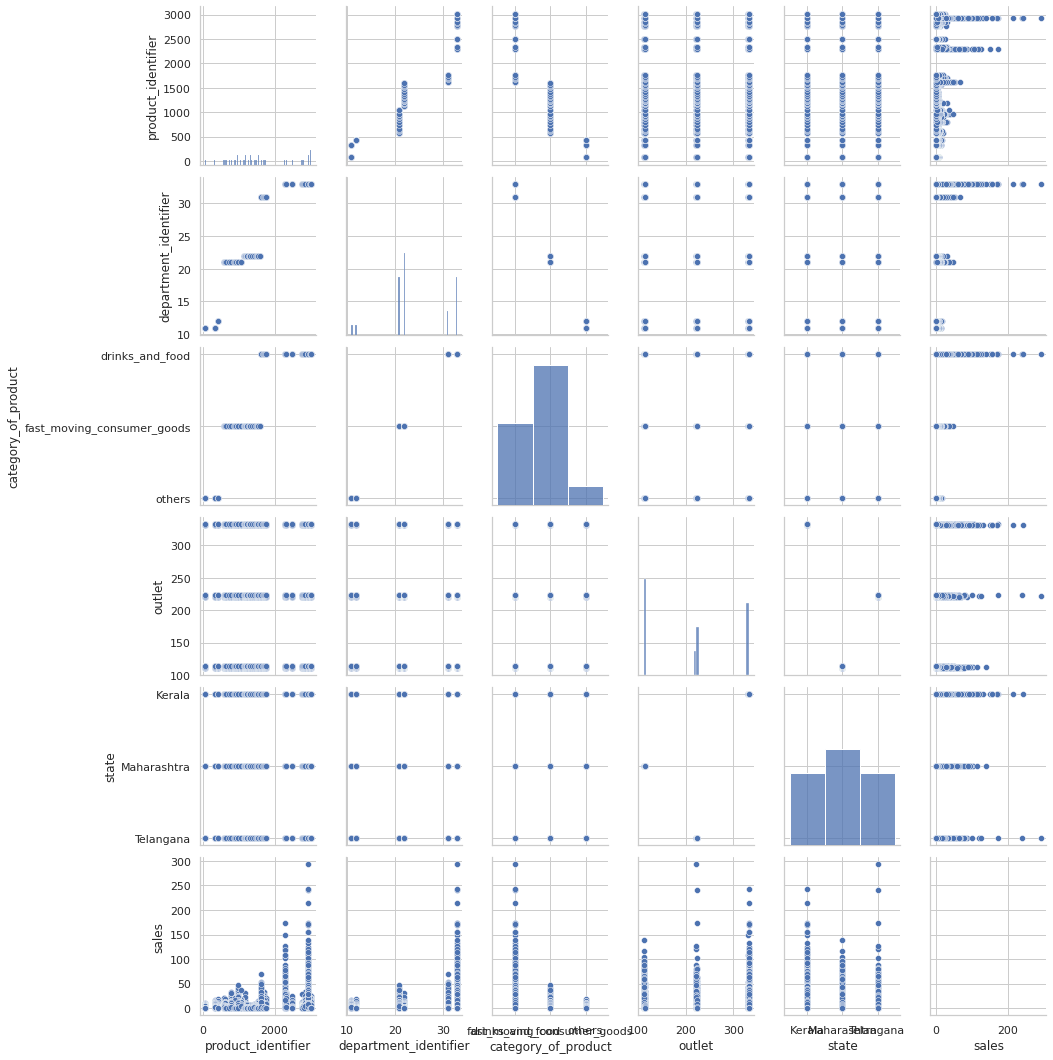

In [ ]:
sns.pairplot(dataset, vars=['product_identifier','department_identifier','category_of_product','outlet','state','sales'])

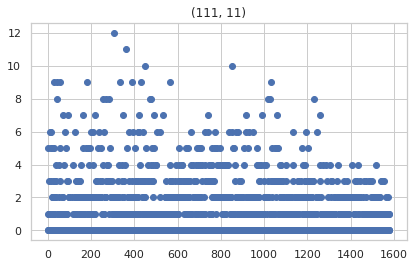

In [ ]:
for name, group in dataset.groupby(["outlet", "department_identifier"]):
    plt.title(name)
    plt.scatter(range(len(group)), group["sales"])
    plt.show()
    break

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
dataset['state_encoded'] = LabelEncoder().fit_transform(dataset['state'])
dataset[['state', 'state_encoded']]

,state,state_encoded
0,Maharashtra,1
1,Maharashtra,1
2,Maharashtra,1
3,Maharashtra,1
4,Maharashtra,1
...,...,...
394995,Kerala,0
394996,Kerala,0
394997,Kerala,0
394998,Kerala,0


In [ ]:
dataset['cat_prod_encoded'] = LabelEncoder().fit_transform(dataset['category_of_product'])
dataset[['category_of_product', 'cat_prod_encoded']]

,category_of_product,cat_prod_encoded
0,others,2
1,others,2
2,others,2
3,others,2
4,fast_moving_consumer_goods,1
...,...,...
394995,drinks_and_food,0
394996,drinks_and_food,0
394997,drinks_and_food,0
394998,drinks_and_food,0


In [ ]:
dataset['Month'] = pd.to_datetime(dataset['date']).dt.month
dataset = dataset.drop(columns=["date","week_id","state","category_of_product"])
dataset

,product_identifier,department_identifier,outlet,sales,sell_price,state_encoded,cat_prod_encoded,Month
0,74,11,111,0,2.94,1,2,1
1,337,11,111,1,7.44,1,2,1
2,423,12,111,0,0.97,1,2,1
3,432,12,111,0,4.97,1,2,1
4,581,21,111,0,4.88,1,1,1
...,...,...,...,...,...,...,...,...
394995,2932,33,333,2,2.78,0,0,2
394996,2935,33,333,8,0.20,0,0,2
394997,3004,33,333,0,2.50,0,0,2
394998,3008,33,333,0,1.98,0,0,2


In [ ]:
def knn():
    knn = KNeighborsRegressor(n_neighbors=10)
    return knn

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return knn()
    return extraTreesRegressor()
#     return svm()
#     return nn()
#     return randomForestRegressor()    

def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)


In [ ]:
from sklearn.model_selection import KFold


foldnum = 10
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in dataset.groupby(["outlet", "department_identifier"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

splited

,product_identifier,department_identifier,outlet,sales,sell_price,state_encoded,cat_prod_encoded,Month,fold
0,74,11,111,0,2.94,1,2,1,0.0
1,337,11,111,1,7.44,1,2,1,0.0
2,74,11,111,0,2.94,1,2,1,0.0
3,337,11,111,5,7.44,1,2,1,0.0
4,74,11,111,1,2.94,1,2,1,0.0
...,...,...,...,...,...,...,...,...,...
394995,2932,33,333,2,2.78,0,0,2,4.0
394996,2935,33,333,8,0.20,0,0,2,4.0
394997,3004,33,333,0,2.50,0,0,2,4.0
394998,3008,33,333,0,1.98,0,0,2,4.0


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max
for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    train_y = dataset_train['sales']
    train_x = dataset_train.drop(columns=['sales', 'fold'])
    test_y = dataset_test['sales']
    test_x = dataset_test.drop(columns=['sales', 'fold'])
    print(dataset_train.shape, dataset_test.shape)
    predicted, model = train_and_predict(train_x, train_y, test_x)
    weights = test_x['outlet'].replace(True, 5).replace(False, 1)
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print(fold, error)
    if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model
error_cv /= 5


(316000, 9) (79000, 9)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0 1.2404312579499372
Find best model
(316000, 9) (79000, 9)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 1.1420228546344842
Find best model
(316000, 9) (79000, 9)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 1.181062119673362
(316000, 9) (79000, 9)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 1.1094390015603175
Find best model
(316000, 9) (79000, 9)


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


4 1.1853063028647097


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
if error < best_error:
        print('Find best model')
        best_error = error
        best_model = model

print(best_error)
print(best_model)

1.1094390015603175
ExtraTreesRegressor(n_jobs=1, verbose=1)


In [ ]:
dataset_test = pd.read_csv("/content/test_data.csv", names=['id','date','product_identifier','department_identifier','category_of_product','outlet','state'],sep=',', header=0)
prod_price = pd.read_csv("/content/product_prices.csv",sep=',', header=0,names=['outlet','product_identifier','week_id','sell_price'])
date_week=pd.read_csv("/content/date_to_week_id_map.csv",sep=',',header=0, names=['date','week_id'])

df = pd.merge(prod_price,date_week, on=['week_id'], how='inner')
dataset_test=pd.merge(dataset_test,df, on=['date','product_identifier','outlet'], how='inner')
dataset_test

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88
...,...,...,...,...,...,...,...,...,...
15495,15496,2014-03-31,2932,33,drinks_and_food,333,Kerala,166,2.78
15496,15497,2014-03-31,2935,33,drinks_and_food,333,Kerala,166,0.20
15497,15498,2014-03-31,3004,33,drinks_and_food,333,Kerala,166,2.68
15498,15499,2014-03-31,3008,33,drinks_and_food,333,Kerala,166,1.98


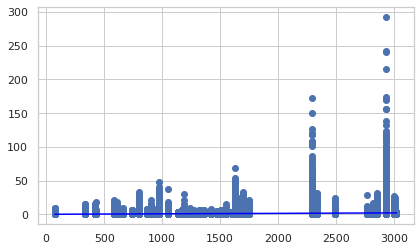

In [ ]:

dataset_test.dtypes

%matplotlib inline
data = pd.read_csv("/content/train_data.csv")
xx = data.iloc[:,1].values.reshape(-1,1)
yy = data.iloc[:,-1].values.reshape(-1,1)
lr = LinearRegression()
lr.fit(xx,yy)
Y_pred = lr.predict(xx)
plt.scatter(xx,yy)
plt.plot(xx,Y_pred,color="blue")
plt.show()

In [ ]:
col = ['category_of_product', 'state']
dataset_test[col] = dataset_test[col].astype('category')

In [ ]:
dataset_test.dtypes

id                          int64
date                       object
product_identifier          int64
department_identifier       int64
category_of_product      category
outlet                      int64
state                    category
week_id                     int64
sell_price                float64
dtype: object

In [ ]:
dataset_test['state_encoded'] = LabelEncoder().fit_transform(dataset_test['state'])
dataset_test[['state', 'state_encoded']]

,state,state_encoded
0,Maharashtra,1
1,Maharashtra,1
2,Maharashtra,1
3,Maharashtra,1
4,Maharashtra,1
...,...,...
15495,Kerala,0
15496,Kerala,0
15497,Kerala,0
15498,Kerala,0


In [ ]:
dataset_test['cat_prod_encoded'] = LabelEncoder().fit_transform(dataset_test['category_of_product'])
dataset_test[['category_of_product', 'cat_prod_encoded']]

,category_of_product,cat_prod_encoded
0,others,2
1,others,2
2,others,2
3,others,2
4,fast_moving_consumer_goods,1
...,...,...
15495,drinks_and_food,0
15496,drinks_and_food,0
15497,drinks_and_food,0
15498,drinks_and_food,0


In [ ]:
dataset_test['Month'] = pd.to_datetime(dataset_test['date']).dt.month
dataset_test = dataset_test.drop(columns=["date","week_id","state","category_of_product","id"])
dataset_test

,product_identifier,department_identifier,outlet,sell_price,state_encoded,cat_prod_encoded,Month
0,74,11,111,3.43,1,2,3
1,337,11,111,7.78,1,2,3
2,423,12,111,0.97,1,2,3
3,432,12,111,4.97,1,2,3
4,581,21,111,4.88,1,1,3
...,...,...,...,...,...,...,...
15495,2932,33,333,2.78,0,0,3
15496,2935,33,333,0.20,0,0,3
15497,3004,33,333,2.68,0,0,3
15498,3008,33,333,1.98,0,0,3


In [ ]:
predicted_test = best_model.predict(dataset_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [ ]:
dataset_test['sales'] = predicted_test

dataset_test['id'] = dataset_test['outlet'].astype(str) + '_' +  dataset_test['department_identifier'].astype(str)
dataset_test = dataset_test[['id', 'sales']]
dataset_test = dataset_test.rename(columns={'id': 'Id', 'sales': 'sales'})

In [ ]:
dataset_test.to_csv('/content/final_output.csv', index=False)

In [ ]:
data = pd.read_csv("/content/train_data.csv")
data = data.dropna()
data

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0
...,...,...,...,...,...,...,...
394995,2014-02-28,2932,33,drinks_and_food,333,Kerala,2
394996,2014-02-28,2935,33,drinks_and_food,333,Kerala,8
394997,2014-02-28,3004,33,drinks_and_food,333,Kerala,0
394998,2014-02-28,3008,33,drinks_and_food,333,Kerala,0


In [ ]:
model_1 = sm.OLS(data['product_identifier'],data[['sales']].assign(intercept=1))
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     product_identifier   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     9455.
Date:                Wed, 17 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:55:27   Log-Likelihood:            -3.2010e+06
No. Observations:              395000   AIC:                         6.402e+06
Df Residuals:                  394998   BIC:                         6.402e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sales         34.4378      0.354     97.235      0.0